In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm

In [4]:
BASE_PATH = '/kaggle/input/anime-style-transfer/anime-style-transfer/'
df = pd.DataFrame(columns = ['Images', 'Labels', 'Split'])

idx = 0
for split in os.listdir(BASE_PATH):
    images_path = BASE_PATH + split + '/images/'
    labels_path = BASE_PATH + split + '/labels/'
    
    for img, lab in tqdm(zip(os.listdir(images_path), os.listdir(labels_path))):
        img_path = images_path + img
        label_path = labels_path + lab
        df.loc[idx, 'Images'] = img_path
        df.loc[idx, 'Labels'] = label_path
        df.loc[idx, 'Split'] = split
        idx += 1
        
df

93it [00:00, 2485.54it/s]
820it [00:00, 3470.58it/s]


,Images,Labels,Split
0,/kaggle/input/anime-style-transfer/anime-style...,/kaggle/input/anime-style-transfer/anime-style...,test
1,/kaggle/input/anime-style-transfer/anime-style...,/kaggle/input/anime-style-transfer/anime-style...,test
2,/kaggle/input/anime-style-transfer/anime-style...,/kaggle/input/anime-style-transfer/anime-style...,test
3,/kaggle/input/anime-style-transfer/anime-style...,/kaggle/input/anime-style-transfer/anime-style...,test
4,/kaggle/input/anime-style-transfer/anime-style...,/kaggle/input/anime-style-transfer/anime-style...,test
...,...,...,...
908,/kaggle/input/anime-style-transfer/anime-style...,/kaggle/input/anime-style-transfer/anime-style...,train
909,/kaggle/input/anime-style-transfer/anime-style...,/kaggle/input/anime-style-transfer/anime-style...,train
910,/kaggle/input/anime-style-transfer/anime-style...,/kaggle/input/anime-style-transfer/anime-style...,train
911,/kaggle/input/anime-style-transfer/anime-style...,/kaggle/input/anime-style-transfer/anime-style...,train


In [5]:
df_train = df[(df['Images'].str.contains('train')) & (df['Labels'].str.contains('train'))].reset_index(drop=True)
# df_valid = df[(df['Photos'].str.contains('val')) & (df['Sketches'].str.contains('val'))].reset_index(drop=True)
df_test = df[(df['Images'].str.contains('test')) & (df['Labels'].str.contains('test'))].reset_index(drop=True)

print(len(df_train))
# print(len(df_valid))
print(len(df_test))

820
93


In [6]:
df_train.to_csv('train.csv',index=False)
# df_valid.to_csv('valid.csv', index=False)
df_test.to_csv('test.csv', index=False)

In [7]:
img = Image.open('/kaggle/input/anime-style-transfer/anime-style-transfer/train/images/00037.png')
np.array(img).shape

(1024, 1024, 3)

In [8]:
img = Image.open('/kaggle/input/anime-style-transfer/anime-style-transfer/train/labels/00010.png')
np.array(img).shape

(512, 512, 3)

# Dataset 

In [9]:
class Cycle_GAN_Dataset(Dataset):
    def __init__(self, csv_file_path, transform=None):

        self.df = pd.read_csv(csv_file_path)
        self.transform = transform

        assert len(self.df['Images']) == len(self.df['Labels']), \
            "The number of photos and sketches must be equal!"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        real_img_path = self.df.iloc[idx]['Images']
        anime_label_path = self.df.iloc[idx]['Labels']

        real_image = Image.open(real_img_path)#.convert("RGB")  
        anime_image = Image.open(anime_label_path)#.convert("RGB")  

        if self.transform:
            real_image = self.transform(real_image)
            anime_image = self.transform(anime_image)

        return real_image, anime_image

In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
train_dataset = Cycle_GAN_Dataset('./train.csv', transform)
# valid_dataset = Cycle_GAN_Dataset('./valid.csv', transform)
test_dataset = Cycle_GAN_Dataset('./test.csv', transform)

In [12]:
BATCH_SIZE = 8
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
p, s = next(iter(train_dataloader))
s.shape

torch.Size([8, 3, 256, 256])

# Architecture

In [14]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [15]:
class Residual_Block(nn.Module):
    def __init__(self, in_ch = 256, out_ch = 256, k_size = 3, s = 1, p = 1):
        super(Residual_Block, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = in_ch, out_channels = out_ch, kernel_size= k_size, stride = s, padding = p, device=DEVICE)
        self.conv_2 = nn.Conv2d(in_channels = out_ch, out_channels = out_ch, kernel_size= k_size, stride = s, padding = p, device=DEVICE)

        self.norm_1 = nn.InstanceNorm2d(num_features = out_ch, device=DEVICE)
        self.norm_2 = nn.InstanceNorm2d(num_features = out_ch, device=DEVICE)

        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.conv_1(x)
        output = self.norm_1(output)
        output = self.relu(output)
        output = self.conv_2(output)
        output = self.norm_2(output)

        return x + output

In [16]:
# class Generator(nn.Module):
#     def __init__(self, num_residual_blocks = 6):
#         super(Generator, self).__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size= 7, stride = 1, padding = 3, device=DEVICE),
#             nn.InstanceNorm2d(num_features = 64, device=DEVICE),
#             nn.ReLU(),
#             nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 3, stride = 2, padding = 1, device=DEVICE),
#             nn.InstanceNorm2d(num_features = 128, device=DEVICE),
#             nn.ReLU(),
#             nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size= 3, stride = 2, padding = 1, device=DEVICE),
#             nn.InstanceNorm2d(num_features = 256, device=DEVICE),
#             nn.ReLU()
#         )

#         self.residual_blocks = []

#         for i in range(num_residual_blocks):
#             self.residual_blocks.append(Residual_Block(s=1))
        
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, device = DEVICE),
#             nn.InstanceNorm2d(num_features = 128, device=DEVICE),
#             nn.ReLU(),
#             nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, device = DEVICE),
#             nn.InstanceNorm2d(num_features = 64, device=DEVICE),
#             nn.ReLU(),
#             nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 7, stride = 1, padding = 3, device = DEVICE),
#             nn.Tanh()
#         )

#     def forward(self, x):

#         output = self.encoder(x)
        
#         for block in self.residual_blocks:
#             output = block(output)

#         output = self.decoder(output)

#         return output

In [17]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        s = self.pool(x).view(b, c)
        s = self.fc(s).view(b, c, 1, 1)
        return x * s

In [18]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_blocks=3, channels=256):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size= 7, stride = 1, padding = 3, device=DEVICE),
            nn.InstanceNorm2d(num_features = 64, device=DEVICE),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 3, stride = 2, padding = 1, device=DEVICE),
            nn.InstanceNorm2d(num_features = 128, device=DEVICE),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size= 3, stride = 2, padding = 1, device=DEVICE),
            nn.InstanceNorm2d(num_features = 256, device=DEVICE),
            nn.ReLU()
        )
            
        self.first_residual = Residual_Block(channels)
        self.middle = nn.Sequential(*[SEBlock(channels) for _ in range(n_blocks)])
        self.last_residual = Residual_Block(channels)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, device = DEVICE),
            nn.InstanceNorm2d(num_features = 128, device=DEVICE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, device = DEVICE),
            nn.InstanceNorm2d(num_features = 64, device=DEVICE),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 7, stride = 1, padding = 3, device = DEVICE),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.first_residual(x)
        x = self.middle(x)
        x = self.last_residual(x)
        return self.decoder(x)

In [19]:
# D1_R(torch.rand(1,3,256,256).to(DEVICE)).shape
# G2_A2R(torch.rand(1,3,256,256).to(DEVICE)).shape

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size= 4, stride = 2, padding = 1, device=DEVICE)
        self.conv_2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 4, stride = 2, padding = 1, device=DEVICE)
        self.conv_3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size= 4, stride = 2, padding = 1, device=DEVICE)
        self.conv_4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size= 4, stride = 2, padding = 1, device=DEVICE)
        self.conv_5 = nn.Conv2d(in_channels = 512, out_channels = 1 , kernel_size= 4, stride = 1, padding = 1, device=DEVICE)

        self.norm_1 = nn.InstanceNorm2d(num_features = 64, device=DEVICE)
        self.norm_2 = nn.InstanceNorm2d(num_features = 128, device=DEVICE)
        self.norm_3 = nn.InstanceNorm2d(num_features = 256, device=DEVICE)
        self.norm_4 = nn.InstanceNorm2d(num_features = 512, device=DEVICE)

        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU(negative_slope = 0.2)

    def forward(self, x):

        output = self.conv_1(x)
        output = self.norm_1(output)
        output = self.leaky_relu(output)
        
        output = self.conv_2(output)
        output = self.norm_2(output)
        output = self.leaky_relu(output)
        
        output = self.conv_3(output)
        output = self.norm_3(output)
        output = self.leaky_relu(output)
        
        output = self.conv_4(output)
        output = self.norm_4(output)
        output = self.leaky_relu(output)
        
        output = self.conv_5(output)
        output = self.sigmoid(output)

        return output

# Model Initialization

In [21]:
G1_R2A = Generator()  # real img -> anime (G) -> G(X) = fake(y) -> F(fake(y)) = reconstructed X
G2_A2R = Generator()  # anime -> real img (F) -> F(Y) = fake (x) -> G(fake(x)) = reconstructed Y
D1_R = Discriminator()  # Real Img discriminator (DX)
D2_A = Discriminator()  # Anime discriminator (DY)

G1_R2A, G2_A2R, D1_R, D2_A = G1_R2A.to(DEVICE), G2_A2R.to(DEVICE), D1_R.to(DEVICE), D2_A.to(DEVICE)

In [22]:
# G1_R2A.load_state_dict(torch.load('./Cycle_GAN_Models/G1_R2A_30.pth'))
# G2_A2R.load_state_dict(torch.load('./Cycle_GAN_Models/G2_A2R_30.pth'))
# D1_R.load_state_dict(torch.load('./Cycle_GAN_Models/D1_R_30.pth'))
# D2_A.load_state_dict(torch.load('./Cycle_GAN_Models/D2_A_30.pth'))

# Losses Initialization

In [23]:
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

adversarial_loss.to(DEVICE)
cycle_loss.to(DEVICE)
identity_loss.to(DEVICE)

L1Loss()

# Optimizers Initialization

In [24]:
LR = 0.0002
BETA_1, BETA_2 = 0.5, 0.99

optimizer_G = optim.Adam(list(G1_R2A.parameters()) + list(G2_A2R.parameters()), lr=LR, betas=(BETA_1, BETA_2))
optimizer_D1_R = optim.Adam(D1_R.parameters(), lr=LR, betas=(BETA_1, BETA_2))
optimizer_D2_A = optim.Adam(D2_A.parameters(), lr=LR, betas=(BETA_1, BETA_2))

# Training

In [25]:
def show_images(real_anime, fake_img, real_img, fake_anime, epoch): 
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Real Sketch -> Generated Photo
    axes[0, 0].imshow(vutils.make_grid(real_anime, normalize=True).permute(1, 2, 0).cpu().numpy())
    axes[0, 0].set_title("Real Anime")
    axes[0, 1].imshow(vutils.make_grid(fake_img, normalize=True).permute(1, 2, 0).cpu().numpy())
    axes[0, 1].set_title("Generated Image")

    # Real Photo -> Generated Sketch
    axes[1, 0].imshow(vutils.make_grid(real_img, normalize=True).permute(1, 2, 0).cpu().numpy())
    axes[1, 0].set_title("Real Image")
    axes[1, 1].imshow(vutils.make_grid(fake_anime, normalize=True).permute(1, 2, 0).cpu().numpy())
    axes[1, 1].set_title("Generated Anime")

    fig.text(0.5, 0.63, f"Epoch {epoch}", fontsize=15, ha='center')
    for ax in axes.flatten():
        ax.axis('off')
    
    plt.subplots_adjust(wspace=-0.1, hspace=-0.8)  
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

100%|██████████| 103/103 [03:05<00:00,  1.80s/it]


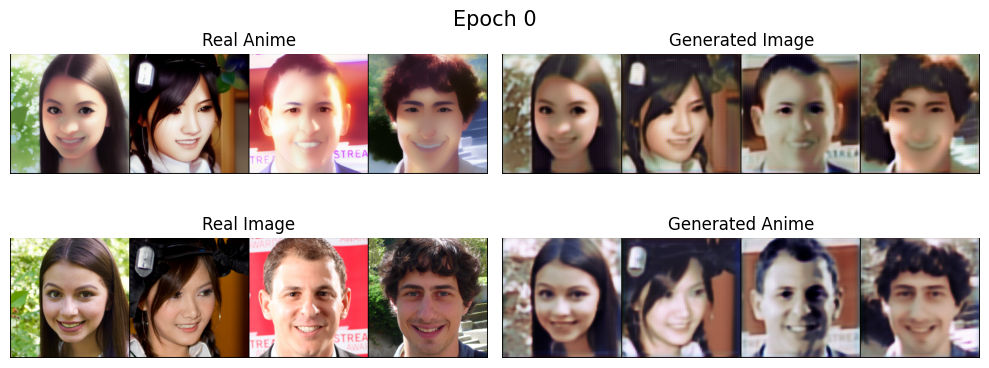

loss_G: 8.170551300048828 - loss_G_identity: 2.1360995769500732 - loss_G_GAN: 0.7739052772521973 - loss_G_cycle: 5.260546684265137 
 loss_D: 0.3953954577445984


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 6.944782257080078 - loss_G_identity: 1.6888474225997925 - loss_G_GAN: 0.9921609163284302 - loss_G_cycle: 4.263772010803223 
 loss_D: 0.3066832423210144


100%|██████████| 103/103 [03:05<00:00,  1.81s/it]


loss_G: 6.583985805511475 - loss_G_identity: 1.5388158559799194 - loss_G_GAN: 1.1478137969970703 - loss_G_cycle: 3.8973581790924072 
 loss_D: 0.2512209415435791


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 6.075127124786377 - loss_G_identity: 1.4253809452056885 - loss_G_GAN: 1.0817251205444336 - loss_G_cycle: 3.5680220127105713 
 loss_D: 0.2908157408237457


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 5.992275714874268 - loss_G_identity: 1.3961912393569946 - loss_G_GAN: 1.087467908859253 - loss_G_cycle: 3.5086166858673096 
 loss_D: 0.2804762125015259


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


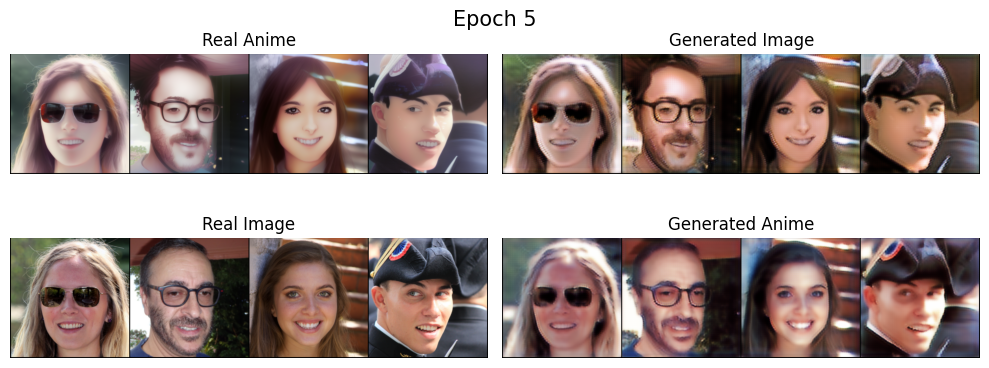

loss_G: 5.68126106262207 - loss_G_identity: 1.3089665174484253 - loss_G_GAN: 1.0934807062149048 - loss_G_cycle: 3.2788147926330566 
 loss_D: 0.28121501207351685


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 5.565062999725342 - loss_G_identity: 1.2765952348709106 - loss_G_GAN: 1.0977410078048706 - loss_G_cycle: 3.190725326538086 
 loss_D: 0.2841077744960785


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 5.420310020446777 - loss_G_identity: 1.237794041633606 - loss_G_GAN: 1.1128456592559814 - loss_G_cycle: 3.069671869277954 
 loss_D: 0.2635558247566223


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 5.436732769012451 - loss_G_identity: 1.2326006889343262 - loss_G_GAN: 1.1350836753845215 - loss_G_cycle: 3.0690479278564453 
 loss_D: 0.2621760666370392


100%|██████████| 103/103 [03:05<00:00,  1.81s/it]


loss_G: 5.3741302490234375 - loss_G_identity: 1.204408049583435 - loss_G_GAN: 1.1570723056793213 - loss_G_cycle: 3.0126497745513916 
 loss_D: 0.2460833340883255


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


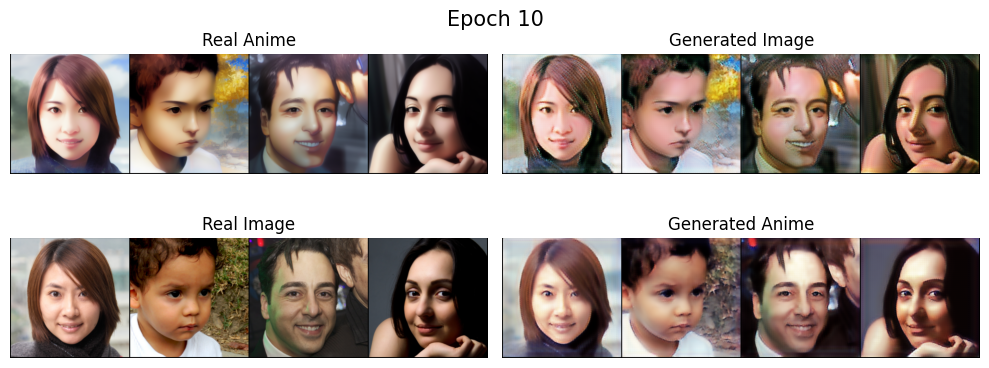

loss_G: 5.231064319610596 - loss_G_identity: 1.1721775531768799 - loss_G_GAN: 1.1497060060501099 - loss_G_cycle: 2.9091806411743164 
 loss_D: 0.2529291808605194


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 5.091256618499756 - loss_G_identity: 1.1333155632019043 - loss_G_GAN: 1.155950665473938 - loss_G_cycle: 2.801990509033203 
 loss_D: 0.2557957172393799


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 5.052872657775879 - loss_G_identity: 1.1207789182662964 - loss_G_GAN: 1.1684538125991821 - loss_G_cycle: 2.7636404037475586 
 loss_D: 0.23801884055137634


100%|██████████| 103/103 [03:05<00:00,  1.81s/it]


loss_G: 5.148361682891846 - loss_G_identity: 1.1218396425247192 - loss_G_GAN: 1.2294009923934937 - loss_G_cycle: 2.797121524810791 
 loss_D: 0.22051027417182922


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 5.007129192352295 - loss_G_identity: 1.098160743713379 - loss_G_GAN: 1.1934528350830078 - loss_G_cycle: 2.7155158519744873 
 loss_D: 0.25183340907096863


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


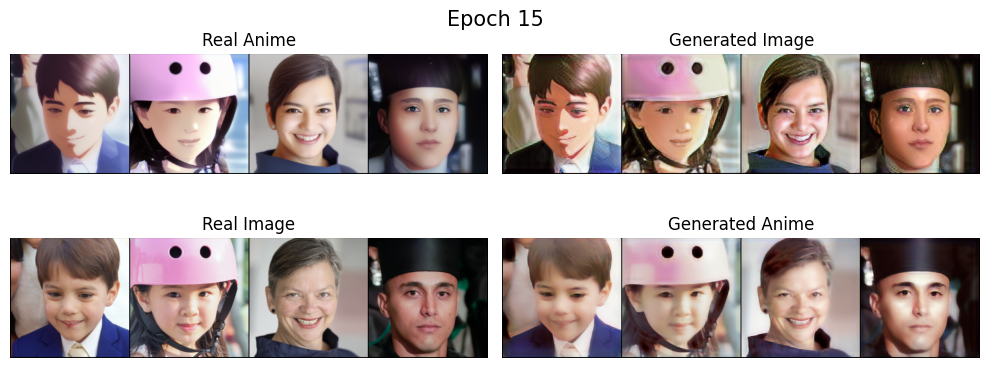

loss_G: 4.880755424499512 - loss_G_identity: 1.0656815767288208 - loss_G_GAN: 1.2033075094223022 - loss_G_cycle: 2.6117677688598633 
 loss_D: 0.2213960438966751


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 4.880006790161133 - loss_G_identity: 1.0575757026672363 - loss_G_GAN: 1.2203675508499146 - loss_G_cycle: 2.602062940597534 
 loss_D: 0.21787655353546143


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 4.780653476715088 - loss_G_identity: 1.0308871269226074 - loss_G_GAN: 1.2186661958694458 - loss_G_cycle: 2.5311005115509033 
 loss_D: 0.2179543823003769


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 4.7216877937316895 - loss_G_identity: 1.012192964553833 - loss_G_GAN: 1.2185074090957642 - loss_G_cycle: 2.4909870624542236 
 loss_D: 0.2224915325641632


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 4.731531143188477 - loss_G_identity: 1.0029710531234741 - loss_G_GAN: 1.254743218421936 - loss_G_cycle: 2.473817825317383 
 loss_D: 0.2058131843805313


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


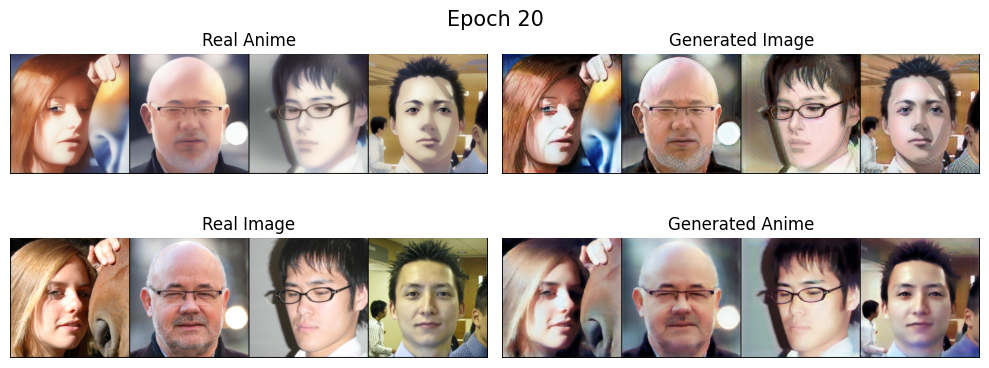

loss_G: 4.746144771575928 - loss_G_identity: 0.9993199706077576 - loss_G_GAN: 1.2774394750595093 - loss_G_cycle: 2.469383716583252 
 loss_D: 0.19686704874038696


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 4.6657185554504395 - loss_G_identity: 0.9799823760986328 - loss_G_GAN: 1.2680745124816895 - loss_G_cycle: 2.4176619052886963 
 loss_D: 0.20516295731067657


100%|██████████| 103/103 [03:06<00:00,  1.81s/it]


loss_G: 4.6270318031311035 - loss_G_identity: 0.96418297290802 - loss_G_GAN: 1.2834446430206299 - loss_G_cycle: 2.379403591156006 
 loss_D: 0.19308951497077942


  2%|▏         | 2/103 [00:03<02:49,  1.68s/it]

In [ ]:
EPOCHS = 30
CL, IL = 10.0, 5.0
TRAIN_LOSS, VAL_LOSS = [], []

for epoch in range(EPOCHS):
    LOSS_G, LOSS_G_IDENTITY, LOSS_G_GAN, LOSS_G_CYCLE, LOSS_D = 0.0, 0.0, 0.0, 0.0, 0.0
    
    for real_photo, real_sketch in tqdm(train_dataloader): # real_photo = real_img, real_sketch = real_anime

        real_photo, real_sketch = real_photo.to(DEVICE), real_sketch.to(DEVICE)

        # ------------------------ Generators P2S and S2P -------------------
        optimizer_G.zero_grad()

        # Identity loss
        identity_photo = G2_A2R(real_photo)
        loss_identity_photo = identity_loss(identity_photo, real_photo) * IL # G2_A2R(P) should be equal to P if real P is fed
        identity_sketch = G1_R2A(real_sketch)
        loss_identity_sketch = identity_loss(identity_sketch, real_sketch) * IL # G1_R2A(S) should be equal to S if real S is fed

        # Adversarial losses for real and fake photos
        fake_photo = G2_A2R(real_sketch) # real_anime -> fake_img
        pred_fake_photo = D1_R(fake_photo)
        loss_G2_A2R = adversarial_loss(pred_fake_photo, torch.ones_like(pred_fake_photo, requires_grad=False))
        
        fake_sketch = G1_R2A(real_photo)
        pred_fake_sketch = D2_A(fake_sketch) 
        loss_G1_R2A = adversarial_loss(pred_fake_sketch, torch.ones_like(pred_fake_sketch, requires_grad=False))

        # Cycle consistency loss
        reconstructed_sketch = G1_R2A(fake_photo)
        loss_cycle_G_S2P2S = cycle_loss(reconstructed_sketch, real_sketch) * 12.0 # CL 

        reconstructed_photo = G2_A2R(fake_sketch)
        loss_cycle_G_P2S2P = cycle_loss(reconstructed_photo, real_photo) * CL
                
        # Total loss
        loss_G = loss_identity_sketch + loss_identity_photo + loss_G2_A2R + loss_G1_R2A + loss_cycle_G_S2P2S + loss_cycle_G_P2S2P
        loss_G.backward()
        optimizer_G.step()

        # ----------- Discriminator 2 -----------
        optimizer_D2_A.zero_grad()

        pred_real_sketch = D2_A(real_sketch)
        loss_real_sketch = adversarial_loss(pred_real_sketch, torch.ones_like(pred_real_sketch, requires_grad=False))

        pred_fake_sketch = D2_A(fake_sketch.detach())
        loss_fake_sketch = adversarial_loss(pred_fake_sketch, torch.zeros_like(pred_fake_sketch, requires_grad=False))

        loss_D2_A = (loss_real_sketch + loss_fake_sketch) * 0.5
        loss_D2_A.backward()

        optimizer_D2_A.step()

        # ----------- Discriminator 1 ---------------
        optimizer_D1_R.zero_grad()

        pred_real_photo = D1_R(real_photo)
        loss_real_photo = adversarial_loss(pred_real_photo, torch.ones_like(pred_real_photo, requires_grad=False))
        
        pred_fake_photo = D1_R(fake_photo.detach())  
        loss_fake_photo = adversarial_loss(pred_fake_photo, torch.zeros_like(pred_fake_photo, requires_grad=False))        

        loss_D1_R = (loss_real_photo + loss_fake_photo) * 0.5
        loss_D1_R.backward()

        optimizer_D1_R.step()

        LOSS_G += loss_G
        LOSS_G_IDENTITY += loss_identity_sketch + loss_identity_photo
        LOSS_G_GAN += loss_G1_R2A + loss_G2_A2R
        LOSS_G_CYCLE += loss_cycle_G_S2P2S + loss_cycle_G_P2S2P
        LOSS_D += loss_D2_A + loss_D1_R

    if ((epoch) % 5) == 0:
        with torch.no_grad():
            show_images(real_sketch, fake_photo, real_photo, fake_sketch, epoch)

    if ((epoch) % 3) == 0:
        torch.save(G1_R2A.state_dict(), f'/kaggle/working/G1_R2A_{epoch}.pth')
        torch.save(G2_A2R.state_dict(), f'/kaggle/working/G2_A2R_{epoch}.pth')
        torch.save(D1_R.state_dict(), f'/kaggle/working/D1_R_{epoch}.pth')
        torch.save(D2_A.state_dict(), f'/kaggle/working/D2_A_{epoch}.pth')

    l = len(train_dataloader)
    print(f"loss_G: {LOSS_G/l} - loss_G_identity: {LOSS_G_IDENTITY/l} - loss_G_GAN: {LOSS_G_GAN/l} - loss_G_cycle: {LOSS_G_CYCLE/l} \n loss_D: {LOSS_D/l}")